# Load And Verify MNIST Dataset

In [ ]:
#load Mnist dataset
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),# Convert PIL Image to tensor
                                transforms.Normalize((0.5,), (0.5,))])# Normalize the tensor with mean 0.5 and std 0.5

# Download and load the training data
trainset = datasets.MNIST(root='./data', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)#initialize the training dataloader

# Download and load the test data
testset = datasets.MNIST(root='./data', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)#initialize the testing dataloader


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 90468909.79it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 17201887.79it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 47578988.12it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3954032.54it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Shape of images batch: torch.Size([64, 1, 28, 28])
Shape of labels batch: torch.Size([64])


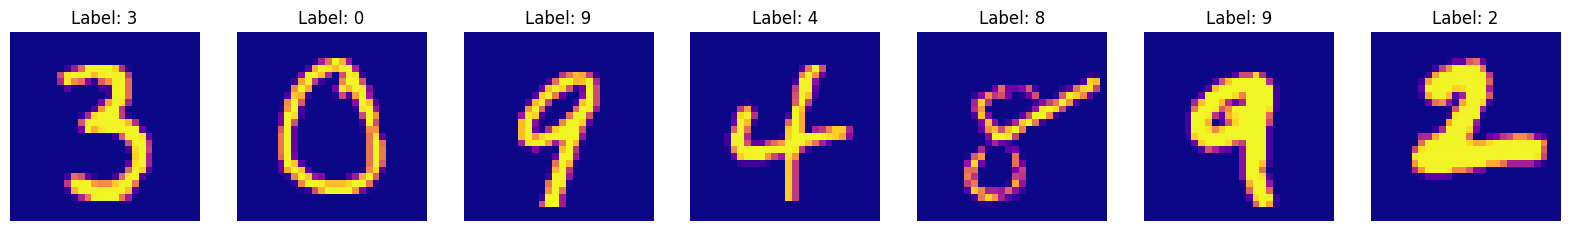

Labels of the first few images: [3 0 9 4 8 9 2]


In [ ]:
#verification of mnist dataset if it is loaded correctly
import matplotlib.pyplot as plt

# Get a batch of training data
dataiter = iter(trainloader)
images, labels = next(dataiter)

#inspect shape of the data
print(f"Shape of images batch: {images.shape}")  # Should be [batch_size, 1, 28, 28]
print(f"Shape of labels batch: {labels.shape}")  # Should be [batch_size]

# Plot the first few images in the batch
fig, axes = plt.subplots(1, 7, figsize=(20, 8))#figsize(length,width) is the size of the image (1,7) is the row and column respectively

for i in range(7):
    ax = axes[i]
    ax.imshow(images[i].numpy().squeeze(), cmap='plasma')
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
plt.show()

# Print some labels
print(f"Labels of the first few images: {labels[:7].numpy()}")

In [ ]:
#check data distribution
import numpy as np

# Check class distribution in the training set
all_labels = np.array([label for _, label in trainset])
unique, counts = np.unique(all_labels, return_counts=True)
print("Class distribution in training set:", dict(zip(unique, counts)))#this line will print which digit is present and how many times


Class distribution in training set: {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


# Define the Deep Learning Model

# Training And Evaluating the Models

In [ ]:

def train_model(model, trainloader, criterion, optimizer, epochs=5):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize the weights
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")


In [ ]:
def evaluate_model(model, testloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients during evaluation
        for images, labels in testloader:
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')
    return accuracy


# Model 1: Fully Connected Layers Only

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        # First fully connected layer: input size is 28*28 (784), output size is 128
        self.fc1 = nn.Linear(28*28, 128)
        # Second fully connected layer: input size is 128, output size is 64
        self.fc2 = nn.Linear(128, 64)
        # Output layer: input size is 64, output size is 10 (for 10 classes)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
          # Flatten the input image to a vector of size 28*28
        x = x.view(x.shape[0], -1)
        # Apply ReLU activation after the first layer
        x = F.relu(self.fc1(x))
        # Apply ReLU activation after the second layer
        x = F.relu(self.fc2(x))
        # The output layer (no activation function here as we'll use CrossEntropyLoss which includes softmax)
        x = self.fc3(x)
        return x

model_FCNN= FullyConnectedNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_FCNN.parameters(), lr=0.001)

# Train the model
print("Training Fully Connected NN")
train_model(model_FCNN, trainloader, criterion, optimizer, epochs=5)

# Evaluate the model
print("Evaluating Fully Connected NN")
evaluate_model(model_FCNN, testloader)

Training Fully Connected NN
Epoch 1, Loss: 0.4007385290269531
Epoch 2, Loss: 0.19964399562676005
Epoch 3, Loss: 0.14512037498745392
Epoch 4, Loss: 0.11595266823297434
Epoch 5, Loss: 0.09812547196435538
Evaluating Fully Connected NN
Accuracy: 96.15%


96.15

# Model 2: Convolution Layer(cnn) with Fully connected layer


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConvFCNN(nn.Module):
    def __init__(self):
        super(ConvFCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(12*12*64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        #
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_ConvFCNN = ConvFCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ConvFCNN.parameters(), lr=0.001)

# Train the model
print("Training Convolution Layer followed By Fully Connected NN")
train_model(model_ConvFCNN, trainloader, criterion, optimizer, epochs=5)

# Evaluate the model
print("Evaluating Convolution Layer followed By Fully Connected NN")
evaluate_model(model_ConvFCNN, testloader)


Training Convolution Layer followed By Fully Connected NN
Epoch 1, Loss: 0.13763329816777617
Epoch 2, Loss: 0.0395606169567085
Epoch 3, Loss: 0.02489973922937871
Epoch 4, Loss: 0.01704170387905899
Epoch 5, Loss: 0.012598285487172355
Evaluating Convolution Layer followed By Fully Connected NN
Accuracy: 98.81%


98.81

# Model 3: Convolution Layer Only

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConvOnlyNN(nn.Module):
    def __init__(self):
        super(ConvOnlyNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 10, 3, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        return x

model_CNN = ConvOnlyNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CNN.parameters(), lr=0.001)

# Train the model
print("Training Convolution Layer followed By Fully Connected NN")
train_model(model_CNN, trainloader, criterion, optimizer, epochs=5)

# Evaluate the model
print("Evaluating Convolution Layer followed By Fully Connected NN")
evaluate_model(model_CNN, testloader)

Training Convolution Layer followed By Fully Connected NN
Epoch 1, Loss: 1.6927807361586515
Epoch 2, Loss: 1.5124307531537786
Epoch 3, Loss: 1.4907286868674923
Epoch 4, Loss: 1.4805326926301536
Epoch 5, Loss: 1.4699275261049332
Evaluating Convolution Layer followed By Fully Connected NN
Accuracy: 45.6%


45.6

# Save , Load And Fine-Tune the Above Models

In [ ]:
# Save the model
torch.save(model_FCNN.state_dict(), 'fcnn.pth')#Save Fully Connected NN
torch.save(model_ConvFCNN.state_dict(), 'conv_fcnn.pth')#Save Convolution + Fully Connected NN
torch.save(model_CNN.state_dict(), 'cnn.pth')#Save Convolution Only NN


In [ ]:
# Load the Fully Connected Neural Network
fcnn = FullyConnectedNN()
fcnn.load_state_dict(torch.load('fcnn.pth'))

# Load the Convolutional Neural Network with Fully Connected Layers
conv_fcnn = ConvFCNN()
conv_fcnn.load_state_dict(torch.load('conv_fcnn.pth'))

# Load the Convolutional Neural Network only
cnn = ConvOnlyNN()
cnn.load_state_dict(torch.load('cnn.pth'))


<All keys matched successfully>

In [ ]:
# Function to fine-tune the model
def fine_tune_model(model, trainloader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Fine-tuning Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

# Define a new optimizer with a lower learning rate(0.001 to 0.0001)
fine_tune_optimizer1 = torch.optim.Adam(fcnn.parameters(), lr=0.0001)
fine_tune_optimizer2 = torch.optim.Adam(conv_fcnn.parameters(), lr=0.0001)
fine_tune_optimizer3 = torch.optim.Adam(cnn.parameters(), lr=0.0001)

# Fine-tune the models
print("Fine-tuning Fully Connected NN")
fine_tune_model(fcnn, trainloader, criterion, fine_tune_optimizer1, epochs=5)

print("Fine-tuning CNN with Fully Connected Layers")
fine_tune_model(conv_fcnn, trainloader, criterion, fine_tune_optimizer2, epochs=5)

print("Fine-tuning CNN Only")
fine_tune_model(cnn, trainloader, criterion, fine_tune_optimizer3, epochs=5)


Fine-tuning Fully Connected NN
Fine-tuning Epoch 1, Loss: 0.059993018277301226
Fine-tuning Epoch 2, Loss: 0.054164463586644576
Fine-tuning Epoch 3, Loss: 0.051612109468846736
Fine-tuning Epoch 4, Loss: 0.049001166153314915
Fine-tuning Epoch 5, Loss: 0.047241976173263964
Fine-tuning CNN with Fully Connected Layers
Fine-tuning Epoch 1, Loss: 0.0032174164947125564
Fine-tuning Epoch 2, Loss: 0.0010503171241110674
Fine-tuning Epoch 3, Loss: 0.00048680804199906664
Fine-tuning Epoch 4, Loss: 0.00027015486142708964
Fine-tuning Epoch 5, Loss: 0.0001299322322110516
Fine-tuning CNN Only
Fine-tuning Epoch 1, Loss: 1.455502684563716
Fine-tuning Epoch 2, Loss: 1.4534418058039538
Fine-tuning Epoch 3, Loss: 1.4523122187362296
Fine-tuning Epoch 4, Loss: 1.4510427546907845
Fine-tuning Epoch 5, Loss: 1.45037992384388


# K-Fold Validation For Above Models on Different-Folds

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold

# Load the MNIST dataset
dataset = datasets.MNIST(root='./data', download=True, transform=transform)


def k_fold_cross_validation(model_x, dataset, k=5, epochs=5):
    kfold = KFold(n_splits=k, shuffle=True)
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold+1}")

        # Sample elements randomly from a given list of indices
        train_subsampler = Subset(dataset, train_idx)
        val_subsampler = Subset(dataset, val_idx)

        # Data loaders for training and validation
        trainloader = DataLoader(train_subsampler, batch_size=64, shuffle=True)
        valloader = DataLoader(val_subsampler, batch_size=64, shuffle=False)

        # Initialize the model, loss function, and optimizer
        model = model_x
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Train the model
        train_model(model, trainloader, criterion, optimizer, epochs)

        # Evaluate the model
        accuracy = evaluate_model(model, valloader)
        print(f"Fold {fold+1}, Accuracy: {accuracy}%")
        fold_accuracies.append(accuracy)

    # Average accuracy over all folds
    avg_accuracy = np.mean(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy}%")
    return avg_accuracy

# Perform k-fold cross-validation on each model
print("Fully Connected NN")
avg_accuracy_fcnn = k_fold_cross_validation(model_FCNN, dataset, k=5, epochs=5)

print("CNN with Fully Connected Layers")
avg_accuracy_conv_fcnn = k_fold_cross_validation(model_ConvFCNN, dataset, k=5, epochs=5)

print("CNN Only")
avg_accuracy_cnn = k_fold_cross_validation(model_CNN, dataset, k=5, epochs=5)


Fully Connected NN
Fold 1
Epoch 1, Loss: 0.08728804208524525
Epoch 2, Loss: 0.07588313108341148
Epoch 3, Loss: 0.069806946101288
Epoch 4, Loss: 0.06258402658277191
Epoch 5, Loss: 0.05721754161873832
Accuracy: 96.95%
Fold 1, Accuracy: 96.95%
Fold 2
Epoch 1, Loss: 0.06454268632053087
Epoch 2, Loss: 0.05512779823876918
Epoch 3, Loss: 0.04797848355351016
Epoch 4, Loss: 0.04516941714442024
Epoch 5, Loss: 0.041544691671617326
Accuracy: 97.64166666666667%
Fold 2, Accuracy: 97.64166666666667%
Fold 3
Epoch 1, Loss: 0.0477740075228891
Epoch 2, Loss: 0.04022758175820733
Epoch 3, Loss: 0.03625379839547289
Epoch 4, Loss: 0.03645489517042491
Epoch 5, Loss: 0.0334070903614435
Accuracy: 98.625%
Fold 3, Accuracy: 98.625%
Fold 4
Epoch 1, Loss: 0.03928224645143685
Epoch 2, Loss: 0.029096386918293624
Epoch 3, Loss: 0.031112700552213938
Epoch 4, Loss: 0.027308843256750454
Epoch 5, Loss: 0.025568456996144958
Accuracy: 98.6%
Fold 4, Accuracy: 98.6%
Fold 5
Epoch 1, Loss: 0.03109425994374518
Epoch 2, Loss: 0.0

# Data Loader For Dog-Cat Classifier

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

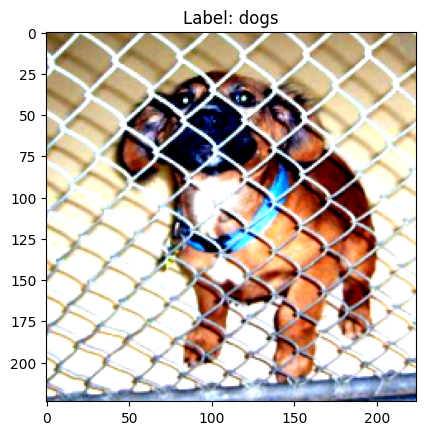

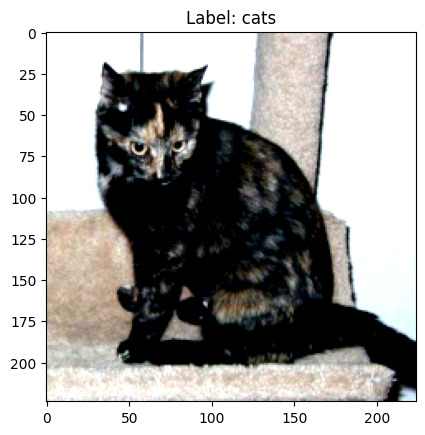

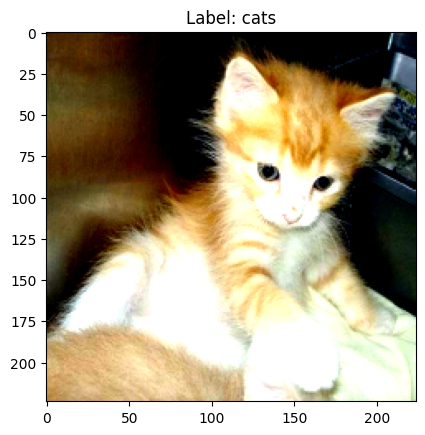

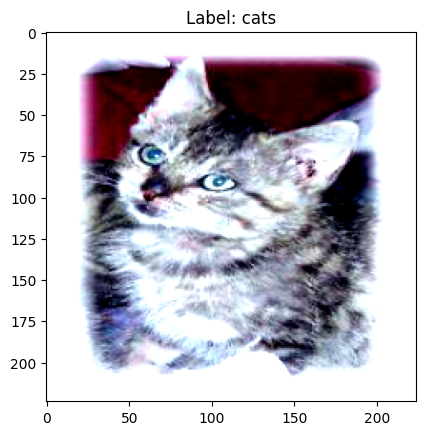

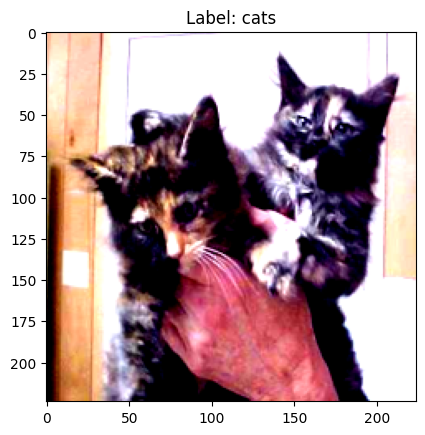

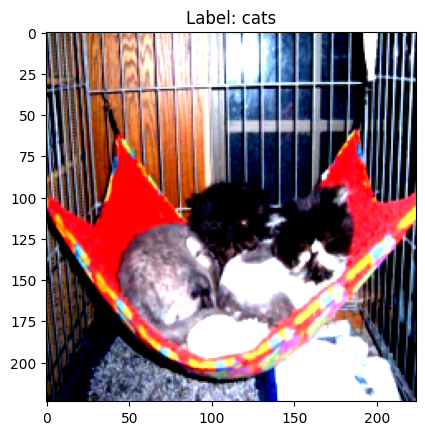

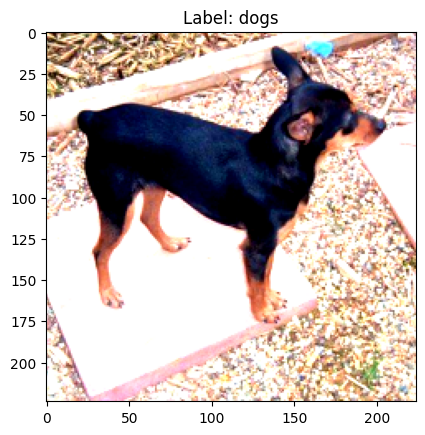

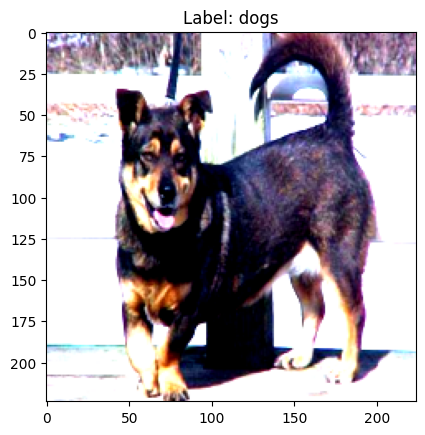

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Custom dataset class
class DogCatDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['dogs', 'cats']
        self.file_list = self._get_file_list()

    def _get_file_list(self):
        file_list = []
        for cls in self.classes:
            cls_dir = os.path.join(self.root_dir, cls)
            if os.path.exists(cls_dir):
                files = os.listdir(cls_dir)
                files = [os.path.join(cls_dir, file) for file in files if file.endswith(('jpg', 'jpeg', 'png'))]
                file_list.extend(files)
        return file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.classes.index(os.path.basename(os.path.dirname(img_path)))

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Instantiate the custom dataset
train_dataset = DogCatDataset(root_dir='/content/train', transform=transform)
val_dataset = DogCatDataset(root_dir='/content/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Function to show an image
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images and labels
for i in range(8):
    imshow(images[i], title=f'Label: {train_dataset.classes[labels[i]]}')
